## 태양광 발전량 예측

In [4]:
import pandas as pd
import seaborn as sns
import pandas_profiling
from matplotlib import pyplot as plt
import numpy as np


df = pd.read_csv('train/train.csv')
df.info()
"""
Hour - 시간
Minute - 분
DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
DNI - 직달일사량(Direct Normal Irradiance (W/m2))
WS - 풍속(Wind Speed (m/s))
RH - 상대습도(Relative Humidity (%))
T - 기온(Temperature (Degree C))
Target - 태양광 발전량 (kW)
"""
df['Minute'].replace(30, 0.5, inplace=True)
df['Time'] = df['Hour'] + df['Minute']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


### 전체 날의 누적 TARGET

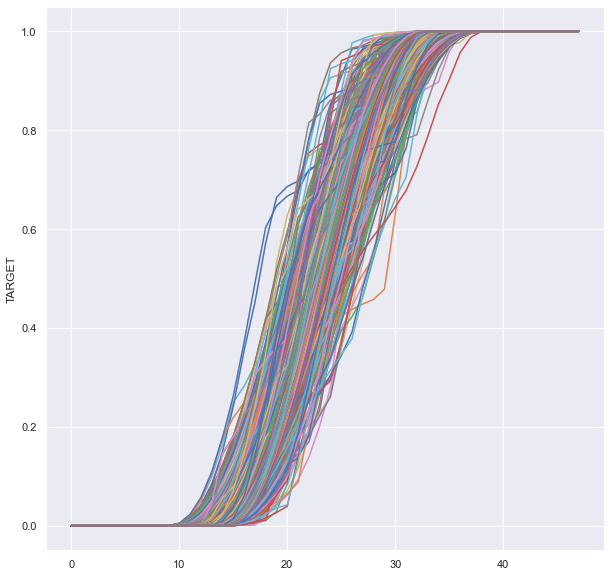

In [171]:
from sklearn import preprocessing

plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
for i in range(1095):
    data = df[df['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data)

### 매년 첫 100일간의 누적 TARGET

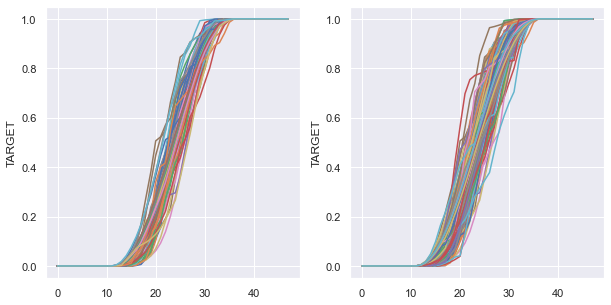

In [70]:
from sklearn import preprocessing

# 왼쪽은 1년의 앞 100일, 오른쪽은 매년의 앞 100일
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.set(style="darkgrid")
for i in range(100):
    data = df[df['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0])
    sns.lineplot(data = data, legend=True, ax=axes[1])

for i in range(365, 465):
    data = df[df['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1])
    
for i in range(730, 830):
    data = df[df['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1])

### 추가 피쳐 생성
1주일 중 최대 TARGET 값을 구합니다.

In [6]:
temp_df_agg = pd.DataFrame()
c='TARGET'
temp_df_agg[f'max_week_{c}'] = df.groupby('Day')[c].max().rolling(7, center=True).max()
temp_df_agg[f'min_week_{c}'] = df.groupby('Day')[c].min().rolling(7, center=True).min()

temp_df_agg[f'max_week_{c}'].iloc[:3] = temp_df_agg.iloc[3][f'max_week_{c}']
temp_df_agg[f'max_week_{c}'].iloc[-3:] = temp_df_agg.iloc[-4][f'max_week_{c}']
temp_df_agg[f'min_week_{c}'].iloc[:3] = temp_df_agg.iloc[3][f'min_week_{c}']
temp_df_agg[f'min_week_{c}'].iloc[-3:] = temp_df_agg.iloc[-4][f'min_week_{c}']
temp_df_agg = temp_df_agg.reset_index()
df_eda = pd.merge(df, temp_df_agg, left_on='Day', right_on='Day')

In [7]:
df_eda['max_week_TARGET'].describe()

count    52560.000000
mean        76.741963
std         17.370722
min         41.946313
25%         59.587508
50%         80.683452
75%         92.323984
max         99.913939
Name: max_week_TARGET, dtype: float64

구한 주 단위 최대 TARGET에서 매 시점의 TARGET을 빼 최대 발전량과 실제 발전량의 차이(peak_diff)를 구합니다.  
이후 하루단위로 peak_diff의 평균값을 구하고 그 날의 흐림 정도(cloudy) 피쳐로 인식합니다.

In [8]:
df_eda['peak_diff'] = df_eda['max_week_TARGET'] - df_eda['TARGET']
df_cloudy = df_eda[df_eda['TARGET'] != 0.0].groupby('Day')['peak_diff'].mean().rename('cloudy')

In [9]:
df_cloudy.describe()

count    1095.000000
mean       41.649896
std        14.752710
min        15.952638
25%        29.829048
50%        40.712863
75%        52.107195
max        84.609374
Name: cloudy, dtype: float64

### 매년 첫 100일의 누적 TARGET
### cloudy 정도에 따른 누적 TARGET

Text(0.5, 1.0, '75% < Cloudy < 100%')

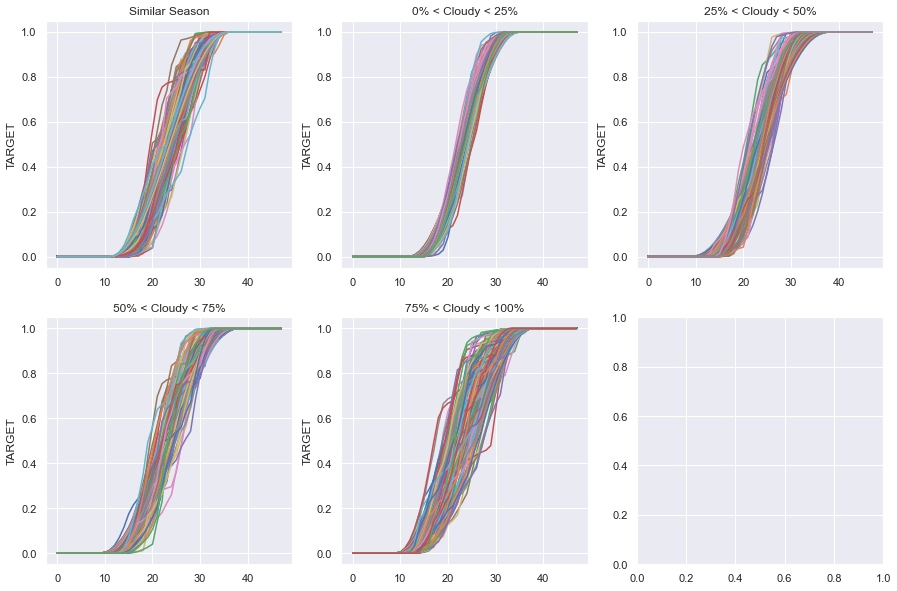

In [97]:
from sklearn import preprocessing

f, axes = plt.subplots(2, 3, figsize=(15,10))
sns.set(style="darkgrid")
for i in range(100):
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0][0])

for i in range(365, 465):
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0][0])
    
for i in range(730, 830):
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0][0])
    

temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[df_cloudy < 29.8])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0][1])
    
temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[(30.0 < df_cloudy) & (df_cloudy < 40.7)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0][2])
    
temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[(40.7 < df_cloudy) & (df_cloudy < 52.1)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1][0])
    
temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[(52.1 < df_cloudy) & (df_cloudy < 84.6)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1][1])
    
axes[0, 0].set_title("Similar Season")
axes[0, 1].set_title("0% < Cloudy < 25%")
axes[0, 2].set_title("25% < Cloudy < 50%")
axes[1, 0].set_title("50% < Cloudy < 75%")
axes[1, 1].set_title("75% < Cloudy < 100%")

Text(0.5, 1.0, '66% < Cloudy < 100%')

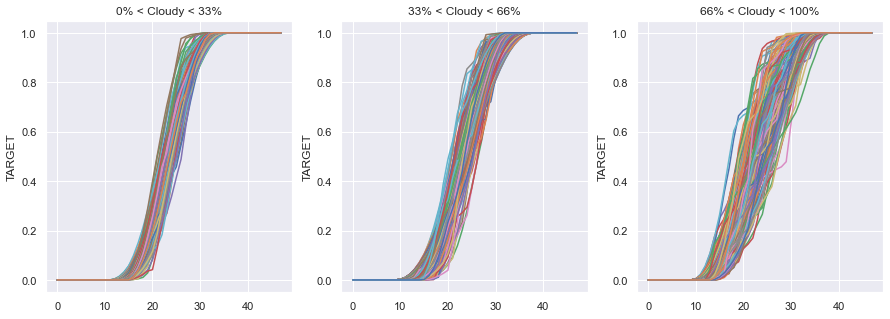

In [106]:
from sklearn import preprocessing

f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(style="darkgrid")

temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[df_cloudy < 33.126562])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0])
    
temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[(33.126562 < df_cloudy) & (df_cloudy < 47.321152)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1])
    
temp_df = df_eda[df_eda['Day'].isin(df_cloudy.index[(47.321152 < df_cloudy) & (df_cloudy < 84.609374)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[2])
    
axes[0].set_title("0% < Cloudy < 33%")
axes[1].set_title("33% < Cloudy < 66%")
axes[2].set_title("66% < Cloudy < 100%")

### 최대 발전량에 따른 누적 TARGET 분포

Text(0.5, 1.0, '66% < max_TARGET < 100%')

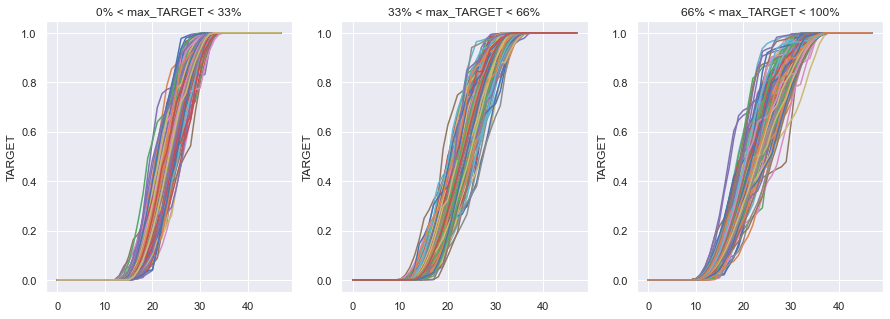

In [122]:
from sklearn import preprocessing

f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(style="darkgrid")

temp_df = df_eda[df_eda['Day'].isin(temp_df_agg.index[temp_df_agg['max_week_TARGET'] < 67.277096])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[0])
    
temp_df = df_eda[df_eda['Day'].isin(temp_df_agg.index[(67.277096 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 89.984244)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[1])
    
temp_df = df_eda[df_eda['Day'].isin(temp_df_agg.index[(89.984244 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 99.913939)])]
for i in temp_df['Day'].unique():
    data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
    data /= data.max()
    sns.lineplot(data = data, legend=True, ax=axes[2])
    
axes[0].set_title("0% < max_TARGET < 33%")
axes[1].set_title("33% < max_TARGET < 66%")
axes[2].set_title("66% < max_TARGET < 100%")

### max_target별 해뜨는 시각과 해지는 시각 시각화

C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:11: UserWa

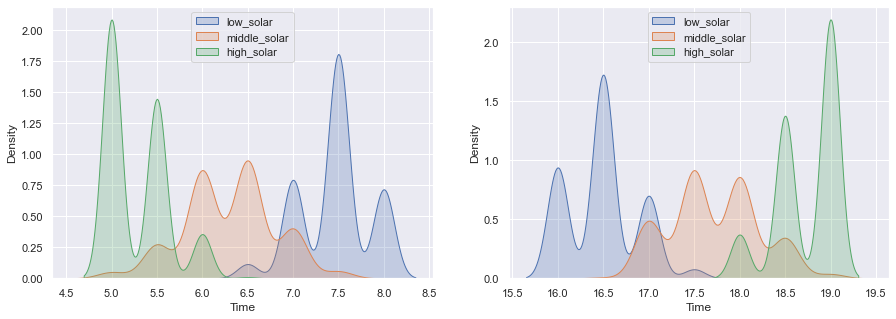

In [170]:
sns.set(style="darkgrid")
f, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[temp_df_agg['max_week_TARGET'] < 67.277096])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].min(), label='low_solar', ax=axes[0], fill=True)
sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[(67.277096 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 89.984244)])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].min(), label='middle_solar', ax=axes[0], fill=True)
sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[(89.984244 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 99.913939)])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].min(), label='high_solar', ax=axes[0], fill=True)

axes[0].legend(loc='upper center')
sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[temp_df_agg['max_week_TARGET'] < 67.277096])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].max(), label='low_solar', ax=axes[1], fill=True)
sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[(67.277096 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 89.984244)])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].max(), label='middle_solar', ax=axes[1], fill=True)
sns.kdeplot(data=df_eda[df_eda['Day'].isin(temp_df_agg.index[(89.984244 < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < 99.913939)])][df_eda['TARGET'] != 0.0].groupby('Day')['Time'].max(), label='high_solar', ax=axes[1], fill=True)

axes[1].legend(loc='upper center')

### 겨울과 여름의 누적 TARGET 분포 비교

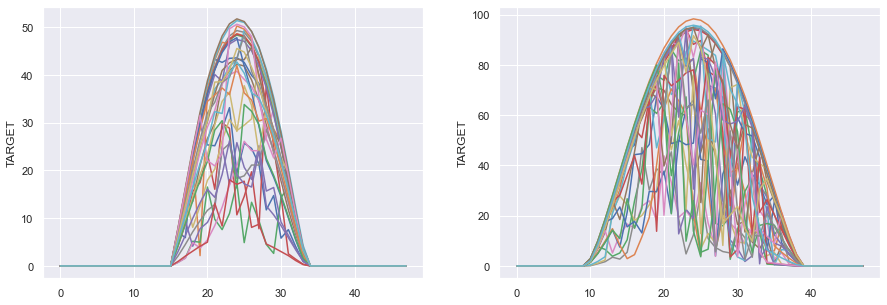

In [176]:
sns.set(style="darkgrid")
f, axes = plt.subplots(1, 2, figsize=(15, 5))

term = 10
for i in range(term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[0])

for i in range(365, 365 + term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[0])
    
for i in range(730, 730 + term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[0])
    

term = 10
for i in range(180, 180+term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[1])

for i in range(365+180, 365+180 + term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[1])
    
for i in range(730+180, 730+180 + term):
    data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
    sns.lineplot(data = data, legend=True, ax=axes[1])
    

### day=21 (가장 맑은 날) 의 누적 TARGET과 TARGET 히스토그램

C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel

<AxesSubplot:xlabel='TARGET', ylabel='Frequency'>

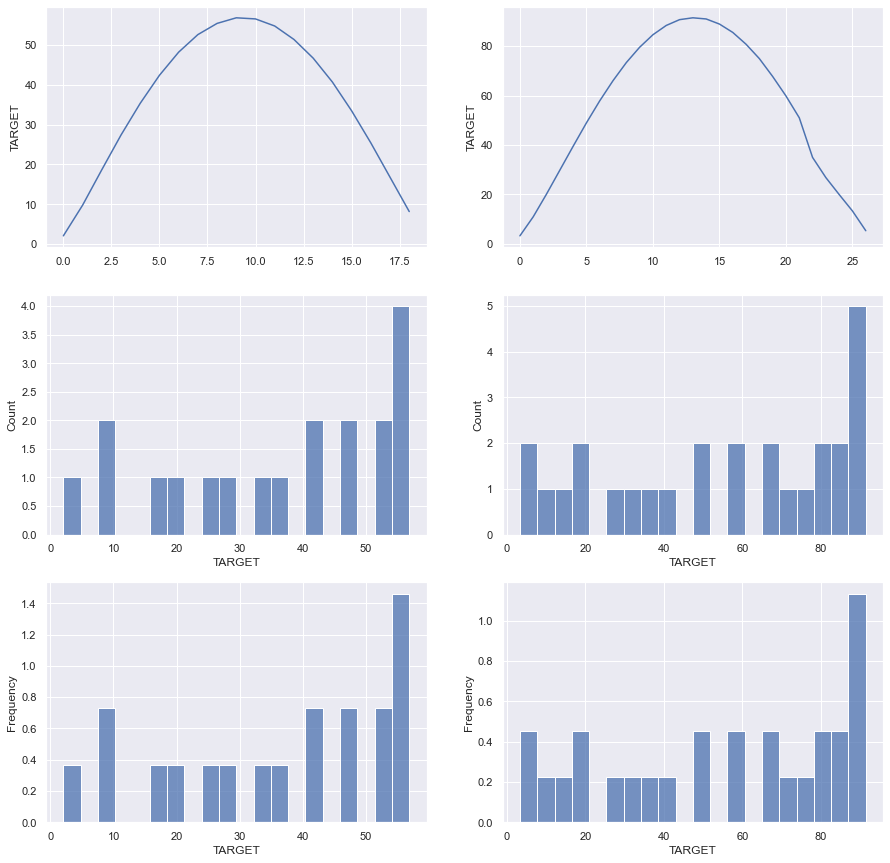

In [30]:
sns.set(style="darkgrid")
f, axes = plt.subplots(3, 2, figsize=(15, 15))

data = df_eda[df_eda['Day'] == 21][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.lineplot(data = data, ax=axes[0][0])

data = df_eda[df_eda['Day'] == 220][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.lineplot(data = data, ax=axes[0][1])

data = df_eda[df_eda['Day'] == 21][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.histplot(data = data, ax=axes[1][0], bins=20)

data = df_eda[df_eda['Day'] == 220][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.histplot(data = data, ax=axes[1][1], bins=20)

data = df_eda[df_eda['Day'] == 21][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.histplot(data = data, stat='frequency', ax=axes[2][0], bins=20)

data = df_eda[df_eda['Day'] == 220][df_eda['TARGET'] != 0.0]['TARGET'].reset_index()['TARGET']
sns.histplot(data = data, stat='frequency', ax=axes[2][1], bins=20)

peak_diff를 최대 발전량으로 나누어 스케일링 시켜준다.

In [12]:
df_eda['peak_diff'] = df_eda['max_week_TARGET'] - df_eda['TARGET']
df_eda['peak_diff_scaled'] = df_eda['peak_diff'] / df_eda['max_week_TARGET']
df_cloudy = df_eda[df_eda['TARGET'] != 0.0].groupby('Day')['peak_diff_scaled'].mean().rename('cloudy')

### max_target과 cloudy별 누적 TARGET 분포

1, 1 count is 7200
1, 2 count is 5328
1, 3 count is 4704
2, 1 count is 6192
2, 2 count is 5232
2, 3 count is 6048
3, 1 count is 3984
3, 2 count is 6768
3, 3 count is 7104


Text(0.5, 1.0, '66% < Cloudy < 100%, 66% < max_TARGET < 100%')

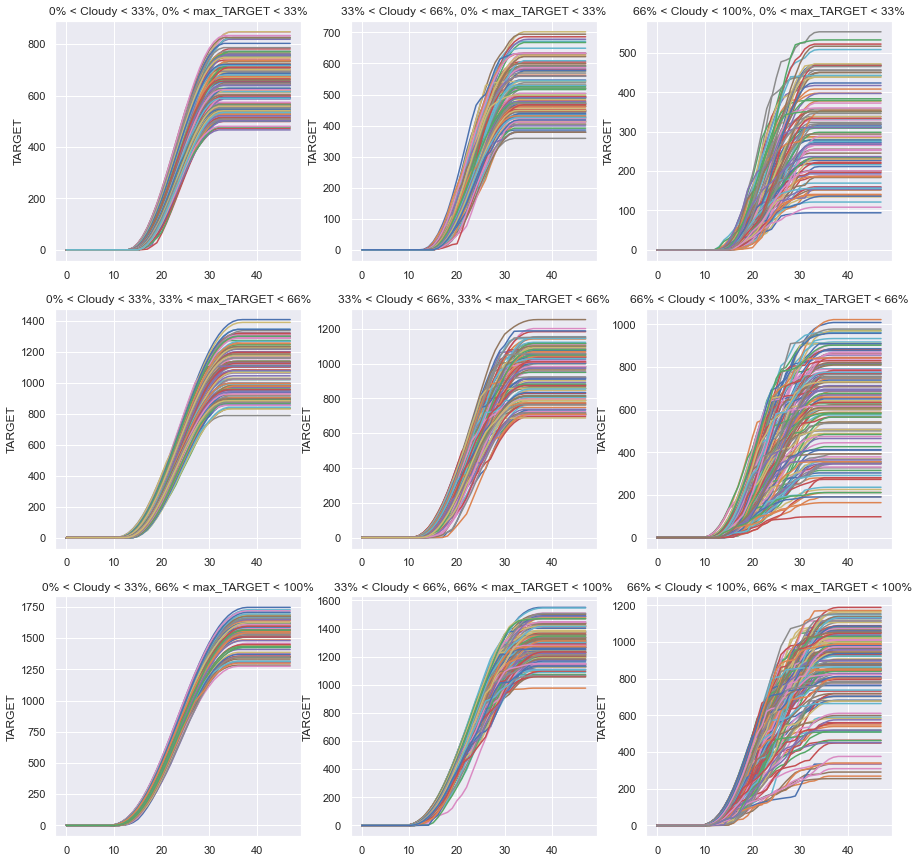

In [53]:
from sklearn import preprocessing

f, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.set(style="darkgrid")

cc = [0.334636, 0.448270, 0.580842, 0.937836]
tt = [41.946313, 67.277096, 89.984244, 99.913939]

for t in range(1, 4):
    for c in range(1, 4):
        condition = (df_cloudy[(cc[c-1] < df_cloudy) & (df_cloudy < cc[c])].index) & (temp_df_agg[(tt[t-1] < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < tt[t])].index)
        temp_df = df_eda[df_eda['Day'].isin(condition)]
        for i in temp_df['Day'].unique():
            data = df_eda[df_eda['Day'] == i]['TARGET'].cumsum().reset_index()['TARGET']
#             data /= data.max()
            sns.lineplot(data = data, legend=False, ax=axes[t-1][c-1])
        print(f'{t}, {c} count is {len(temp_df)}')
    
axes[0][0].set_title("0% < Cloudy < 33%, 0% < max_TARGET < 33%")
axes[0][1].set_title("33% < Cloudy < 66%, 0% < max_TARGET < 33%")
axes[0][2].set_title("66% < Cloudy < 100%, 0% < max_TARGET < 33%")
axes[1][0].set_title("0% < Cloudy < 33%, 33% < max_TARGET < 66%")
axes[1][1].set_title("33% < Cloudy < 66%, 33% < max_TARGET < 66%")
axes[1][2].set_title("66% < Cloudy < 100%, 33% < max_TARGET < 66%")
axes[2][0].set_title("0% < Cloudy < 33%, 66% < max_TARGET < 100%")
axes[2][1].set_title("33% < Cloudy < 66%, 66% < max_TARGET < 100%")
axes[2][2].set_title("66% < Cloudy < 100%, 66% < max_TARGET < 100%")

### max_target과 cloudy별 TARGET 분포

1, 1 count is 7200
1, 2 count is 5328
1, 3 count is 4704
2, 1 count is 6192
2, 2 count is 5232
2, 3 count is 6048
3, 1 count is 3984
3, 2 count is 6768
3, 3 count is 7104


Text(0.5, 1.0, '66% < Cloudy < 100%, 66% < max_TARGET < 100%')

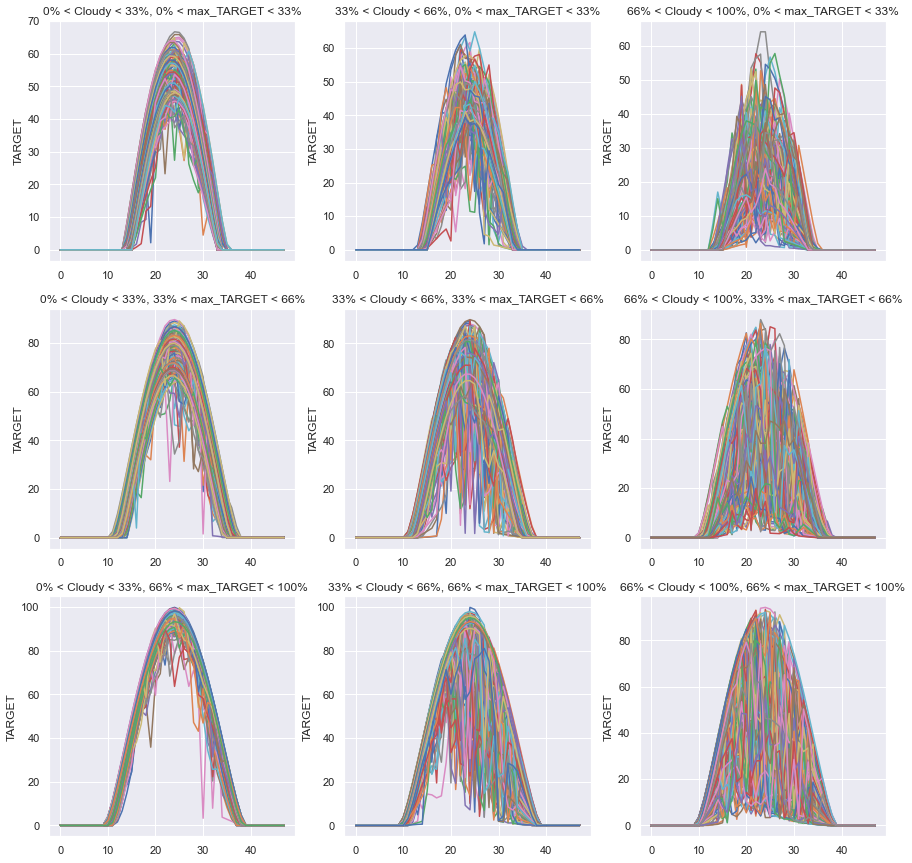

In [54]:
from sklearn import preprocessing

f, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.set(style="darkgrid")

cc = [0.334636, 0.448270, 0.580842, 0.937836]
tt = [41.946313, 67.277096, 89.984244, 99.913939]

for t in range(1, 4):
    for c in range(1, 4):
        condition = (df_cloudy[(cc[c-1] < df_cloudy) & (df_cloudy < cc[c])].index) & (temp_df_agg[(tt[t-1] < temp_df_agg['max_week_TARGET']) & (temp_df_agg['max_week_TARGET'] < tt[t])].index)
        temp_df = df_eda[df_eda['Day'].isin(condition)]
        for i in temp_df['Day'].unique():
            data = df_eda[df_eda['Day'] == i]['TARGET'].reset_index()['TARGET']
#             data /= data.max()
            sns.lineplot(data = data, legend=False, ax=axes[t-1][c-1])
        print(f'{t}, {c} count is {len(temp_df)}')
    
axes[0][0].set_title("0% < Cloudy < 33%, 0% < max_TARGET < 33%")
axes[0][1].set_title("33% < Cloudy < 66%, 0% < max_TARGET < 33%")
axes[0][2].set_title("66% < Cloudy < 100%, 0% < max_TARGET < 33%")
axes[1][0].set_title("0% < Cloudy < 33%, 33% < max_TARGET < 66%")
axes[1][1].set_title("33% < Cloudy < 66%, 33% < max_TARGET < 66%")
axes[1][2].set_title("66% < Cloudy < 100%, 33% < max_TARGET < 66%")
axes[2][0].set_title("0% < Cloudy < 33%, 66% < max_TARGET < 100%")
axes[2][1].set_title("33% < Cloudy < 66%, 66% < max_TARGET < 100%")
axes[2][2].set_title("66% < Cloudy < 100%, 66% < max_TARGET < 100%")

### 보정전 cloudy의 변화

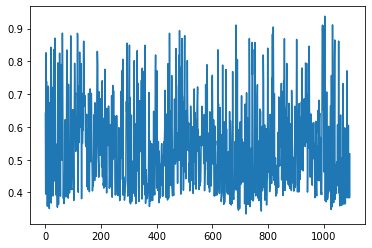

In [16]:
plt.plot(df_cloudy)

### 1년, 2년, 3년의 계절성이 보정된 TARGET 변화
### 3년간의 평균 TARGET 변화

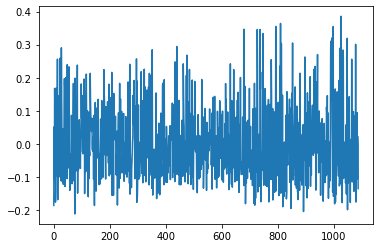

In [41]:
plt.plot((res[4] - res[0]))

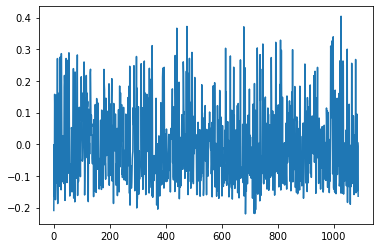

In [42]:
plt.plot((res[4] - res[1]))

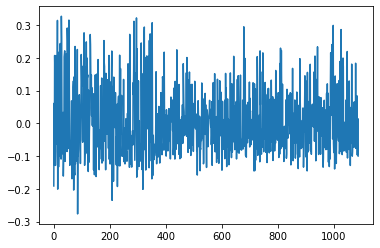

In [43]:
plt.plot((res[4] - res[2]))

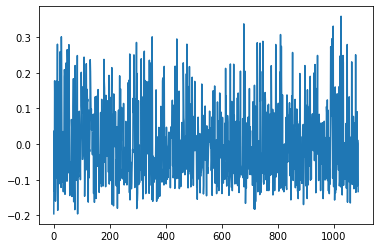

In [44]:
plt.plot((res[4] - res[3]))